**1. Import Data**

In [1]:
from google.colab import files
import pandas as pd

# File upload
uploaded = files.upload()

# Load into dictionary
dataframes = {}
for filename in uploaded.keys():
    try:
        if filename.endswith(".csv"):
            df = pd.read_csv(filename)
        elif filename.endswith((".xls", ".xlsx")):
            df = pd.read_excel(filename)
        else:
            print(f"⚠️ Unsupported file format: {filename}")
            continue
        dataframes[filename.lower()] = df
        print(f"✅ {filename} loaded successfully")
    except Exception as e:
        print(f"❌ Error loading {filename}: {str(e)}")

Saving Company X - Order Report.xlsx to Company X - Order Report.xlsx
Saving Company X - Pincode Zones.xlsx to Company X - Pincode Zones.xlsx
Saving Company X - SKU Master.xlsx to Company X - SKU Master.xlsx
Saving Courier Company - Invoice.xlsx to Courier Company - Invoice.xlsx
Saving Courier Company - Rates.xlsx to Courier Company - Rates.xlsx
✅ Company X - Order Report.xlsx loaded successfully
✅ Company X - Pincode Zones.xlsx loaded successfully
✅ Company X - SKU Master.xlsx loaded successfully
✅ Courier Company - Invoice.xlsx loaded successfully
✅ Courier Company - Rates.xlsx loaded successfully


**2. Data Understanding & Cleaning**

In [2]:
# Show first 5 rows
for filename, df in dataframes.items():
    print(f"\n Cleaning {filename} ")
    print("First 5 rows:")
    print(df.head())


 Cleaning company x - order report.xlsx 
First 5 rows:
   ExternOrderNo            SKU  Order Qty
0     2001827036  8904223818706        1.0
1     2001827036  8904223819093        1.0
2     2001827036  8904223819109        1.0
3     2001827036  8904223818430        1.0
4     2001827036  8904223819277        1.0

 Cleaning company x - pincode zones.xlsx 
First 5 rows:
   Warehouse Pincode  Customer Pincode Zone
0             121003            507101    d
1             121003            486886    d
2             121003            532484    d
3             121003            143001    b
4             121003            515591    d

 Cleaning company x - sku master.xlsx 
First 5 rows:
             SKU  Weight (g)
0  8904223815682         210
1  8904223815859         165
2  8904223815866         113
3  8904223815873          65
4  8904223816214         120

 Cleaning courier company - invoice.xlsx 
First 5 rows:
        AWB Code    Order ID  Charged Weight  Warehouse Pincode  \
0  1091117222

In [3]:
# Check missing values
for filename, df in dataframes.items():
    print(f"\n Missing Values in {filename}:")
    print(df.isnull().sum())


 Missing Values in company x - order report.xlsx:
ExternOrderNo    0
SKU              0
Order Qty        0
dtype: int64

 Missing Values in company x - pincode zones.xlsx:
Warehouse Pincode    0
Customer Pincode     0
Zone                 0
dtype: int64

 Missing Values in company x - sku master.xlsx:
SKU           0
Weight (g)    0
dtype: int64

 Missing Values in courier company - invoice.xlsx:
AWB Code                0
Order ID                0
Charged Weight          0
Warehouse Pincode       0
Customer Pincode        0
Zone                    0
Type of Shipment        0
Billing Amount (Rs.)    0
dtype: int64

 Missing Values in courier company - rates.xlsx:
Zone                                     0
Weight Slabs                             0
Forward Fixed Charge                     0
Forward Additional Weight Slab Charge    0
RTO Fixed Charge                         0
RTO Additional Weight Slab Charge        0
dtype: int64


In [8]:
# Cleaning Function
def clean_df(df):
    # Numeric columns
    for col in df.select_dtypes(include=["float64","int64"]).columns:
        df[col] = df[col].fillna(df[col].mean())

    # Categorical columns
    for col in df.select_dtypes(include=["object"]).columns:
        if not df[col].mode().empty:
            df[col] = df[col].fillna(df[col].mode()[0])

    # Try to convert numeric strings
    for col in df.columns:
        if df[col].dtype == "object":
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                pass

    # Drop duplicates
    df.drop_duplicates(inplace=True)
    return df

In [9]:
# Apply cleaning
for key in dataframes.keys():
    dataframes[key] = clean_df(dataframes[key])

**3. Merge Files**

In [24]:
print("Available keys in dataframes:")
print(dataframes.keys())


Available keys in dataframes:
dict_keys(['company x - order report.xlsx', 'company x - pincode zones.xlsx', 'company x - sku master.xlsx', 'courier company - invoice.xlsx', 'courier company - rates.xlsx'])


In [28]:
#1: Load your cleaned dataframes
order_df   = standardize_columns(dataframes['company x - order report.xlsx'])
sku_df     = standardize_columns(dataframes['company x - sku master.xlsx'])
pincode_df = standardize_columns(dataframes['company x - pincode zones.xlsx'])
invoice_df = standardize_columns(dataframes['courier company - invoice.xlsx'])
rates_df   = standardize_columns(dataframes['courier company - rates.xlsx'])

In [29]:
#2: Merge Order Report with SKU Master (add weight per SKU)
order_merged = order_df.merge(sku_df, on="sku", how="left")
order_merged['total_sku_weight'] = (
    order_merged['order_qty'] * order_merged['weight_g']
)


In [30]:
#3: Aggregate to Order Level
order_weight = (
    order_merged.groupby("externorderno", as_index=False)['total_sku_weight'].sum()
)
order_weight.rename(
    columns={'total_sku_weight': 'total_weight_g',
             'externorderno': 'order_id'},
    inplace=True
)

In [31]:
#4: Add customer_pincode from Invoice
order_with_pincode = order_weight.merge(
    invoice_df[['order_id', 'customer_pincode']],
    on="order_id",
    how="left"
)

In [32]:
#5: Map Zone using pincode file
order_zone = order_with_pincode.merge(
    pincode_df[['customer_pincode', 'zone']],
    on="customer_pincode",
    how="left"
)

In [33]:
#6: Merge with Courier Invoice (billed charges, courier data)
final_master = order_zone.merge(
    invoice_df, on="order_id", how="left", suffixes=("_x", "_courier")
)

In [34]:
#7: Convert weight to KG & standardize date ---
final_master['total_weight_kg'] = final_master['total_weight_g'] / 1000

if 'date' in final_master.columns:
    final_master['date'] = pd.to_datetime(
        final_master['date'], errors='coerce'
    ).dt.strftime('%Y-%m-%d')

In [35]:
#Final check
print(final_master.head(10))
print(final_master.info())

     order_id  total_weight_g  customer_pincode_x zone_x       awb_code  \
0  2001806210           220.0              140604      b  1091117221940   
1  2001806226           480.0              723146      d  1091117222065   
2  2001806229           500.0              421204      d  1091117222080   
3  2001806232          1302.0              507101      d  1091117222124   
4  2001806233           245.0              263139      b  1091117222135   
5  2001806251           245.0              743263      d  1091117222146   
6  2001806273           615.0              486886      d  1091117222194   
7  2001806304           500.0              302017      b  1091117222360   
8  2001806338           500.0              392150      d  1091117222570   
9  2001806408          2265.0              532484      d  1091117222931   

   charged_weight  warehouse_pincode  customer_pincode_courier zone_courier  \
0            2.92             121003                    140604            b   
1            0.6

**4.Expected Charges Calculation**

In [38]:
import math
import pandas as pd

# --- Step 1: Normalize Zones in both datasets ---
rates_df['zone'] = rates_df['zone'].astype(str).str.strip().str.lower()
final_master['zone_x'] = final_master['zone_x'].astype(str).str.strip().str.lower()
final_master['type_of_shipment'] = final_master['type_of_shipment'].astype(str).str.strip()

# --- Step 2: Expected Charge Calculation Function ---
def calculate_expected_charge(row, rates_df):
    zone = row['zone_x']
    weight = row['total_weight_kg']
    shipment_type = row.get('type_of_shipment', 'Forward')  # default Forward

    # Filter rate card for this zone
    zone_rates = rates_df[rates_df['zone'] == zone]
    if zone_rates.empty:
        return None

    # Get the minimum slab size (e.g., 0.5 KG or 0.25 KG)
    min_slab = zone_rates['weight_slabs'].min()

    # Round weight UP to nearest slab multiple
    slabs = math.ceil(weight / min_slab)
    applicable_weight = slabs * min_slab

    # Use the row corresponding to min slab (base charge row)
    rate_row = zone_rates[zone_rates['weight_slabs'] == min_slab].iloc[0]

    # Forward charges
    forward_charge = (
        rate_row['forward_fixed_charge'] +
        (slabs - 1) * rate_row['forward_additional_weight_slab_charge']
    )

    # If shipment type includes RTO
    if "rto" in shipment_type.lower():
        rto_charge = (
            rate_row['rto_fixed_charge'] +
            (slabs - 1) * rate_row['rto_additional_weight_slab_charge']
        )
        total_charge = forward_charge + rto_charge
    else:
        total_charge = forward_charge

    return round(total_charge, 2)

# --- Step 3: Apply Calculation to all rows ---
final_master['expected_charge'] = final_master.apply(
    lambda x: calculate_expected_charge(x, rates_df), axis=1
)

# --- Step 4: Compute Difference (Expected - Actual) ---
final_master['amount_diff'] = (
    final_master['expected_charge'] - final_master['billing_amount_rs']
)

# --- Step 5: Quick Check ---
print(
    final_master[
        ['order_id', 'total_weight_kg', 'zone_x', 'zone_courier',
         'type_of_shipment', 'expected_charge', 'billing_amount_rs', 'amount_diff']
    ].head(15)
)


      order_id  total_weight_kg zone_x zone_courier type_of_shipment  \
0   2001806210            0.220      b            b  Forward charges   
1   2001806226            0.480      d            d  Forward charges   
2   2001806229            0.500      d            d  Forward charges   
3   2001806232            1.302      d            d  Forward charges   
4   2001806233            0.245      b            b  Forward charges   
5   2001806251            0.245      d            d  Forward charges   
6   2001806273            0.615      d            d  Forward charges   
7   2001806304            0.500      b            d  Forward charges   
8   2001806338            0.500      d            d  Forward charges   
9   2001806408            2.265      d            d  Forward charges   
10  2001806446            0.500      d            d  Forward charges   
11  2001806458            0.700      b            b  Forward charges   
12  2001806471            1.621      b            d  Forward cha

5. Summary Table

In [41]:
import math
import pandas as pd

# --- Function: Calculate expected charge based on rate card ---
def calculate_expected_charge(row, rates_df):
    zone = row['zone_x']   # Zone as per Company X
    weight = row['total_weight_kg']
    shipment_type = row.get('type_of_shipment', 'Forward charges')

    # Filter rate card for this zone (case insensitive)
    zone_rates = rates_df[rates_df['zone'].str.lower() == str(zone).lower()]
    if zone_rates.empty or pd.isna(weight):
        return None

    # Base slab (minimum weight slab, e.g., 0.5 kg)
    min_slab = zone_rates['weight_slabs'].min()

    # Round weight UP to nearest multiple of min_slab
    slabs = math.ceil(weight / min_slab)

    # Pick base slab row
    rate_row = zone_rates[zone_rates['weight_slabs'] == min_slab].iloc[0]

    # --- Forward charges ---
    forward_charge = (
        rate_row['forward_fixed_charge']
        + (slabs - 1) * rate_row['forward_additional_weight_slab_charge']
    )

    # --- RTO logic ---
    if "rto" in shipment_type.lower():
        rto_charge = (
            rate_row['rto_fixed_charge']
            + (slabs - 1) * rate_row['rto_additional_weight_slab_charge']
        )
        total_charge = forward_charge + rto_charge
    else:
        total_charge = forward_charge

    return round(total_charge, 2)

# --- Step 6: Apply expected charge calculation ---
final_master['expected_charge'] = final_master.apply(
    lambda x: calculate_expected_charge(x, rates_df), axis=1
)

# --- Step 7: Compute Difference ---
final_master['amount_diff'] = (
    final_master['expected_charge'] - final_master['billing_amount_rs']
)

# --- Step 8: Categorize Orders ---
def categorize(diff):
    if pd.isna(diff):
        return "Unknown"
    elif diff == 0:
        return "Correctly Charged"
    elif diff < 0:
        return "Overcharged"
    else:
        return "Undercharged"

final_master['charge_category'] = final_master['amount_diff'].apply(categorize)

# --- Step 9: Create Summary Table ---
summary_table = (
    final_master.groupby('charge_category')
    .agg(Count=('order_id', 'count'),
         Total_Amount_Diff=('amount_diff', 'sum'))
    .reset_index()
)

# --- Step 10: Export to Excel (with 2 sheets) ---
with pd.ExcelWriter("Courier_Charge_Analysis.xlsx", engine="openpyxl") as writer:
    final_master.to_excel(writer, sheet_name="Order_Level_Report", index=False)
    summary_table.to_excel(writer, sheet_name="Summary_Table", index=False)

print("Analysis Completed. Results exported to 'Courier_Charge_Analysis.xlsx'")

print("\n--- Sample Order Level Report ---")
print(
    final_master[['order_id','zone_x','zone_courier','total_weight_kg',
                  'expected_charge','billing_amount_rs','amount_diff','charge_category']].head(10)
)

print("\n--- Summary Table ---")
print(summary_table)


Analysis Completed. Results exported to 'Courier_Charge_Analysis.xlsx'

--- Sample Order Level Report ---
     order_id zone_x zone_courier  total_weight_kg  expected_charge  \
0  2001806210      b            b            0.220             33.0   
1  2001806226      d            d            0.480             45.4   
2  2001806229      d            d            0.500             45.4   
3  2001806232      d            d            1.302             45.4   
4  2001806233      b            b            0.245             33.0   
5  2001806251      d            d            0.245             45.4   
6  2001806273      d            d            0.615             45.4   
7  2001806304      b            d            0.500             33.0   
8  2001806338      d            d            0.500             45.4   
9  2001806408      d            d            2.265             90.2   

   billing_amount_rs  amount_diff charge_category  
0              174.5       -141.5     Overcharged  
1       

**6.Generate Outputs**

In [43]:
import pandas as pd

# --- Step 1: Define Order-Level Columns (only keep existing ones) ---
order_level_cols = [
    'order_id',
    'total_weight_kg',
    'zone_x',
    'zone_courier',
    'expected_charge',
    'billing_amount_rs',
    'amount_diff',
    'charge_category'
]

# If awb_number exists in final_master, include it
if 'awb_number' in final_master.columns:
    order_level_cols.insert(1, 'awb_number')

# --- Output 1: Order-Level Report ---
order_level_report = final_master[order_level_cols].copy()

# --- Output 2: Summary Table ---
summary_table = (
    final_master.groupby('charge_category')
    .agg(Count=('order_id','count'),
         Total_Amount_Diff=('amount_diff','sum'))
    .reset_index()
)

# --- Export both to Excel & CSV ---
with pd.ExcelWriter("Courier_Charge_Outputs.xlsx", engine="openpyxl") as writer:
    order_level_report.to_excel(writer, sheet_name="Order_Level_Report", index=False)
    summary_table.to_excel(writer, sheet_name="Summary_Table", index=False)

order_level_report.to_csv("Order_Level_Report.csv", index=False)
summary_table.to_csv("Summary_Table.csv", index=False)

print("  Outputs Generated:")
print("- Courier_Charge_Outputs.xlsx (2 sheets)")
print("- Order_Level_Report.csv")
print("- Summary_Table.csv")

print("\n--- Sample Order-Level Report ---")
print(order_level_report.head(10))

print("\n--- Summary Table ---")
print(summary_table)


  Outputs Generated:
- Courier_Charge_Outputs.xlsx (2 sheets)
- Order_Level_Report.csv
- Summary_Table.csv

--- Sample Order-Level Report ---
     order_id  total_weight_kg zone_x zone_courier  expected_charge  \
0  2001806210            0.220      b            b             33.0   
1  2001806226            0.480      d            d             45.4   
2  2001806229            0.500      d            d             45.4   
3  2001806232            1.302      d            d             45.4   
4  2001806233            0.245      b            b             33.0   
5  2001806251            0.245      d            d             45.4   
6  2001806273            0.615      d            d             45.4   
7  2001806304            0.500      b            d             33.0   
8  2001806338            0.500      d            d             45.4   
9  2001806408            2.265      d            d             90.2   

   billing_amount_rs  amount_diff charge_category  
0              174.5    

**7. Exploratory Data Analysis **

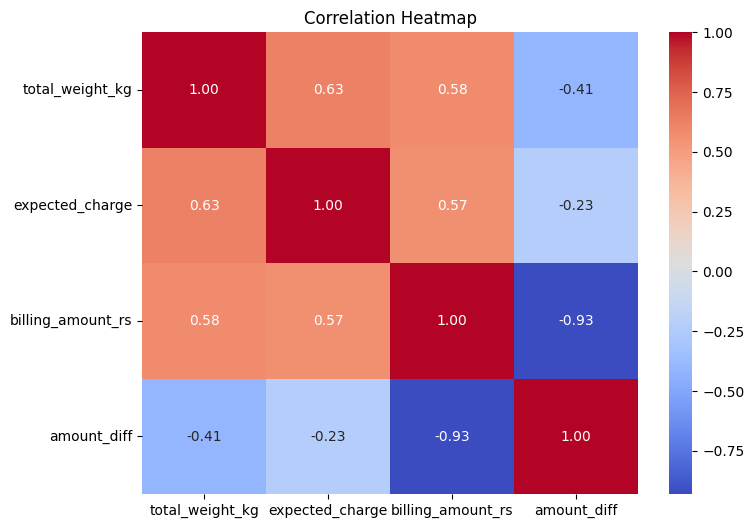

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Correlation Heatmap ---
plt.figure(figsize=(8,6))
numeric_cols = ['total_weight_kg', 'expected_charge', 'billing_amount_rs', 'amount_diff']
corr = final_master[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

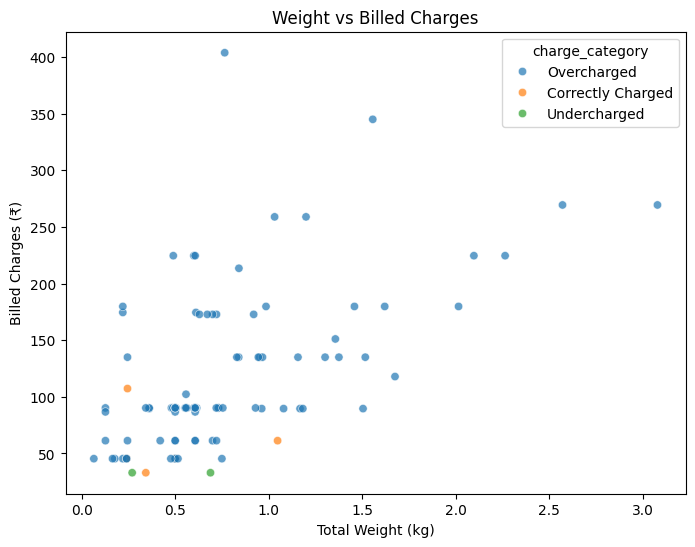

In [45]:
# --- Scatter Plot: Weight vs Billed Charges ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=final_master, x='total_weight_kg', y='billing_amount_rs',
                hue='charge_category', alpha=0.7)
plt.title("Weight vs Billed Charges")
plt.xlabel("Total Weight (kg)")
plt.ylabel("Billed Charges (₹)")
plt.show()

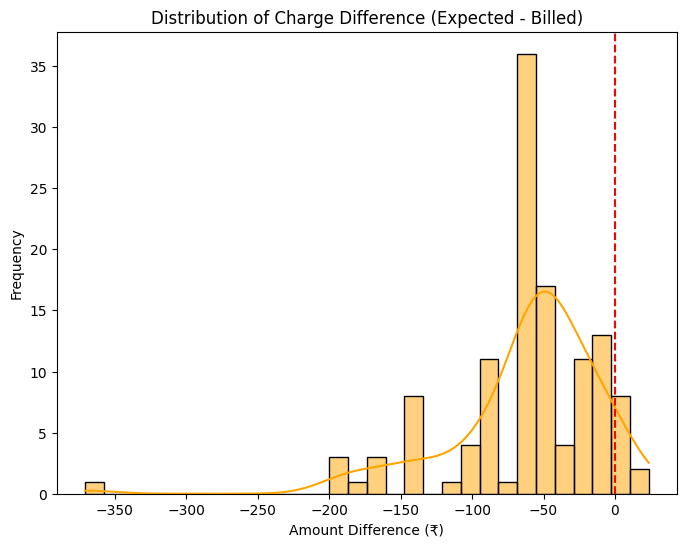

In [46]:
# --- Distribution of Amount Difference (Overcharge/Undercharge) ---
plt.figure(figsize=(8,6))
sns.histplot(final_master['amount_diff'], kde=True, bins=30, color="orange")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of Charge Difference (Expected - Billed)")
plt.xlabel("Amount Difference (₹)")
plt.ylabel("Frequency")
plt.show()

/tmp/ipython-input-4087558837.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_master, x='charge_category', palette="Set2")


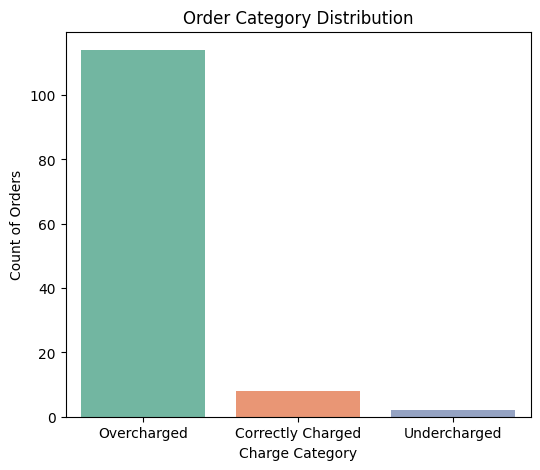

In [47]:
# --- Countplot: Overcharged vs Correct vs Undercharged ---
plt.figure(figsize=(6,5))
sns.countplot(data=final_master, x='charge_category', palette="Set2")
plt.title("Order Category Distribution")
plt.xlabel("Charge Category")
plt.ylabel("Count of Orders")
plt.show()

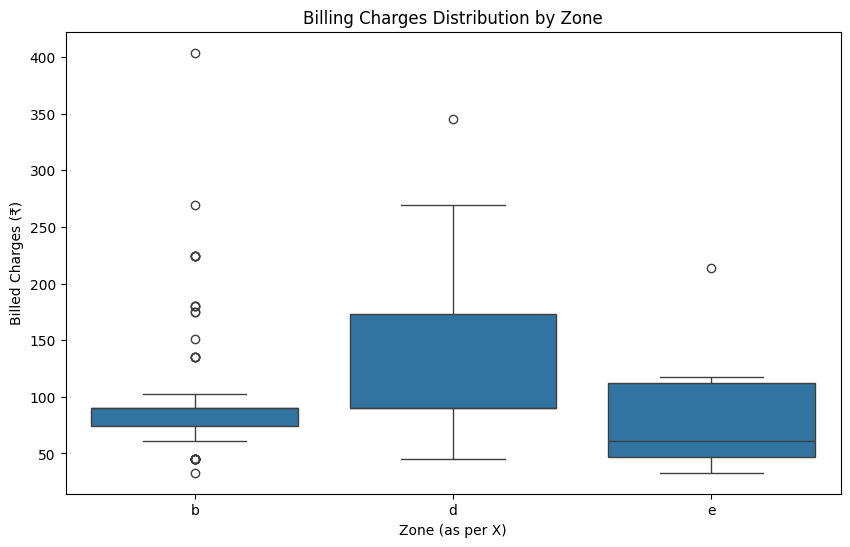

In [48]:
# --- Boxplot: Charges by Zone ---
plt.figure(figsize=(10,6))
sns.boxplot(data=final_master, x='zone_x', y='billing_amount_rs')
plt.title("Billing Charges Distribution by Zone")
plt.xlabel("Zone (as per X)")
plt.ylabel("Billed Charges (₹)")
plt.show()

**8.Machine Learning**

Anomaly Detection

In [49]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on amount_diff
iso = IsolationForest(contamination=0.05, random_state=42)
final_master['anomaly_flag'] = iso.fit_predict(final_master[['amount_diff']])

# Map flags (-1 = anomaly, 1 = normal)
final_master['anomaly_flag'] = final_master['anomaly_flag'].map({1: "Normal", -1: "Suspicious"})

# Quick check
print(final_master[['order_id', 'amount_diff', 'anomaly_flag']].head(10))


     order_id  amount_diff anomaly_flag
0  2001806210       -141.5       Normal
1  2001806226        -44.8       Normal
2  2001806229        -44.8       Normal
3  2001806232        -89.6       Normal
4  2001806233        -28.3       Normal
5  2001806251        -89.6       Normal
6  2001806273        -44.8       Normal
7  2001806304        -57.2       Normal
8  2001806338        -44.8       Normal
9  2001806408       -134.4       Normal


Regression Model – Predict Charges

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features and target
X = final_master[['total_weight_kg', 'zone_x', 'type_of_shipment']]
y = final_master['billing_amount_rs']

# Preprocess categorical columns
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), ['zone_x','type_of_shipment'])],
    remainder='passthrough'
)

# Regression pipeline
reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_model.fit(X_train, y_train)
print("R² Score:", reg_model.score(X_test, y_test))


R² Score: 0.6209605975447337


Classification – Predict Overcharged/Correct/Undercharged

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features & target
X = final_master[['total_weight_kg', 'zone_x', 'type_of_shipment']]
y = final_master['charge_category']

# Preprocess categories
clf_preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), ['zone_x','type_of_shipment'])],
    remainder='passthrough'
)

# Random Forest Classifier
clf_model = Pipeline([
    ('preprocessor', clf_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_model.fit(X_train, y_train)
y_pred = clf_model.predict(X_test)

print(classification_report(y_test, y_pred))


                   precision    recall  f1-score   support

Correctly Charged       1.00      1.00      1.00         2
      Overcharged       1.00      1.00      1.00        23

         accuracy                           1.00        25
        macro avg       1.00      1.00      1.00        25
     weighted avg       1.00      1.00      1.00        25



Save trained model

In [52]:
import pickle

# Assume your model is trained as clf_model
with open("charge_predictor.pkl", "wb") as f:
    pickle.dump(clf_model, f)